In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import fnmatch
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import random

Using TensorFlow backend.


In [2]:
# source: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/notebook
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True) # search pathname/folder to find .png files recursively then parse files
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


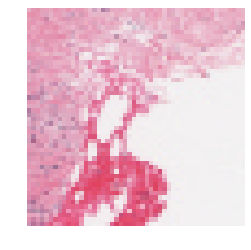

In [3]:
image_name = "IDC_regular_ps50_idx5/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

In [4]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero) #filename pattern matching returns subset of list of names
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']


In [5]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
%time
X,Y = proc_images(0,100000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

Wall time: 0 ns


In [7]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 100000
Number of IDC(-) Images: 70901
Number of IDC(+) Images: 29099
Percentage of positive images: 29.10%
Image shape (Width, Height, Channels): (50, 50, 3)


In [8]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


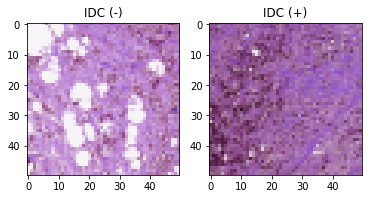

In [9]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 

In [13]:
X=np.array(X)
X=X/255.0

X_train, Y_train, = (X, Y)



In [15]:
#Source: (fashion MNIST) https://www.tensorflow.org/tutorials/keras/basic_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten, Activation
import keras.backend as K

model=Sequential()

model.add(Flatten(input_shape=(50,50,3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Source: (fashion MNIST) https://www.tensorflow.org/tutorials/keras/basic_classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=('adam'),
             metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_split=0.20, epochs=20)

print(history.history.keys())



model.summary()

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 41s 507us/step - loss: 0.5085 - acc: 0.7637 - val_loss: 0.5260 - val_acc: 0.6955
Epoch 2/20
80000/80000 [==============================] - 42s 530us/step - loss: 0.4583 - acc: 0.7896 - val_loss: 0.4864 - val_acc: 0.7204
Epoch 3/20
80000/80000 [==============================] - 42s 531us/step - loss: 0.4543 - acc: 0.7914 - val_loss: 0.5632 - val_acc: 0.6906
Epoch 4/20
80000/80000 [==============================] - 43s 534us/step - loss: 0.4497 - acc: 0.7938 - val_loss: 0.4722 - val_acc: 0.7436
Epoch 5/20
80000/80000 [==============================] - 43s 535us/step - loss: 0.4414 - acc: 0.7979 - val_loss: 0.5092 - val_acc: 0.7172
Epoch 6/20
80000/80000 [==============================] - 43s 538us/step - loss: 0.4353 - acc: 0.8008 - val_loss: 0.5013 - val_acc: 0.7268
Epoch 7/20
80000/80000 [==============================] - 44s 546us/step - loss: 0.4288 - acc: 0.8048 - val_loss: 0.

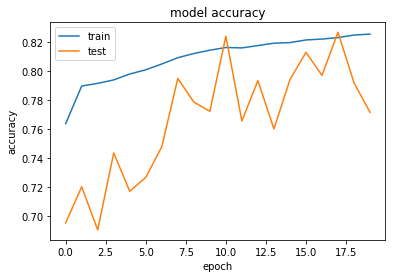

In [16]:
# source: https://keras.io/visualization/
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


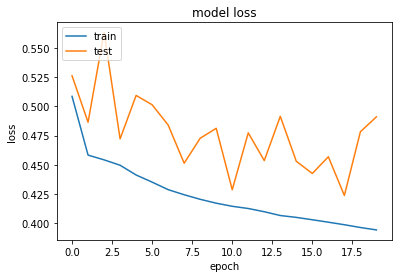

In [17]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()